# Reference
https://github.com/wayofnumbers/SideProjects/blob/master/PyTorch_Tutorial_Basic_v1.ipynb
https://towardsdatascience.com/build-a-fashion-mnist-cnn-pytorch-style-efb297e22582

In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image mainpulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True) # On by default, leave it here for clarity

In [2]:
# check PyTorch versions
print(torch.__version__)
print(torchvision.__version__)

1.3.0
0.4.1a0+d94043a


In [3]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

100.0%

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


111.0%

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


100.0%

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


159.1%

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


In [4]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    # define forward function
    def forward(self, t):
        # conv1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # conv2
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # fc1
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        
        # fc2
        t = self.fc2(t)
        t = F.relu(t)
        
        # output
        t = self.out(t)
        # Don't need softmax here since we'll use cross-entropy as activation.
        
        return t

In [5]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [6]:
# import modules to build RunBuilder and RunManager helper classes
from collections import OrderedDict
from collections import namedtuple
from itertools import product 

# Read in the hyper-parameters and return an Run namedtuple containing all the
# combinations of hyper-parameters
class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run = namedtuple('Run', params.keys())
        
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
            
        return runs

In [14]:
# Helper class, help track loss, accuracy, epoch time, run time,
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
    def __init__(self):
        # tracking every epoch count, loss, accuracy, time
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None
        
        # tracking every run count, run data, hyper-params used, time
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        # record model, loader and TensorBoard
        self.network = None
        self.loader = None
        self.tb = None
        
    # record the count, hyper-param, model, loader, of each run
    # record sample images and network graph to TensorBoard
    def begin_run(self, run, network, loader):
        self.run_start_time = time.time()
        
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}')
        
        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image('images', grid)
        self.tb.add_graph(self.network, images)
        
    # when run ends, close TensorBoard, zero epoch count
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0
        
    # zero epoch count, loss, accuracy
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        
    def end_epoch(self):
        # calculate epoch duration and run duration(accumulate)
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        # record epoch loss and accuracy
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)
        
        # Record epoch loss and accuracy to TensorBoard
        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
        
        # Record params to TensorBoard
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
            
        # Write into 'results' (OrderedDict) for all run related data
        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration
        
        # Record hyper-params into 'results'
        for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')
        
        # display epoch information and show progress
        clear_output(wait=True)
        display(df)
        
    # accumulate loss of batch into entire epoch loss
    def track_loss(self, loss):
        # multiply batch size so variety of batch sizes can be compared
        self.epoch_loss += loss.item() * self.loader.batch_size
        
    # accumulate number of corrects of batch into entire epoch num_correct
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
        
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    # save end results of all runs into csv, json for further a
    def save(self, fileName):
        pd.DataFrame.from_dict(
            self.run_data,
            orient = 'columns',
        ).to_csv(f'{fileName}.csv')
        
        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [9]:
# put all hyper params into a OrderedDict, easily expandable
params = OrderedDict(
    lr = [.01, .001],
    batch_size = [100, 1000],
    shuffle = [False]
)
epochs = 5

In [15]:
m = RunManager()

# get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):
    # if params changes, following line of code should reflect the changes too
    network = Network()
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)
    
    m.begin_run(run, network, loader)
    for epoch in range(epochs):
        m.begin_epoch()
        for batch in loader:
            images = batch[0]
            labels = batch[1]
            preds = network(images)
            loss = F.cross_entropy(preds, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            m.track_loss(loss)
            m.track_num_correct(preds, labels)
            
        m.end_epoch()
    m.end_run()
    
# when all runs are done, save results to files
m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,0.571449,0.782267,26.594129,26.813388,0.010,100,False
1,1,2,0.392156,0.854450,27.466121,54.374132,0.010,100,False
2,1,3,0.355388,0.868517,26.428031,80.887258,0.010,100,False
3,1,4,0.339025,0.874533,27.977539,109.028432,0.010,100,False
4,1,5,0.332280,0.876133,23.992186,133.181335,0.010,100,False
5,2,1,1.109509,0.572750,21.269149,22.285271,0.010,1000,False
6,2,2,0.619620,0.756717,20.850456,43.311929,0.010,1000,False
7,2,3,0.510145,0.807400,24.124801,67.617708,0.010,1000,False
8,2,4,0.430701,0.844667,23.270169,91.119622,0.010,1000,False
9,2,5,0.382091,0.860250,23.015498,114.325462,0.010,1000,False


In [34]:
# helper function to calculate all predictions of train set
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds),
            dim = 0
        )
    return all_preds

In [35]:
# bigger batch size since we only do FP
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=1000)
train_preds = get_all_preds(network, prediction_loader)

In [19]:
!pip install scikit-plot

     |████████████████████████████████| 13.1MB 464kB/s eta 0:00:01
     |████████████████████████████████| 6.7MB 334kB/s eta 0:00:01
     |████████████████████████████████| 25.2MB 1.9MB/s eta 0:00:01
     |████████████████████████████████| 296kB 1.4MB/s eta 0:00:01
     |████████████████████████████████| 71kB 3.5MB/s eta 0:00:011
     |████████████████████████████████| 92kB 2.9MB/s eta 0:00:011
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl


In [36]:
# use scikitplot to plot the confusion matrix
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import scikitplot as skplt

print(train_set.targets.size())
print(train_preds.size())
print(type(prediction_loader))

cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
cm

torch.Size([60000])
torch.Size([60000, 10])
<class 'torch.utils.data.dataloader.DataLoader'>


array([[4734,   24,  121,  543,   65,    9,  445,    1,   56,    2],
       [   3, 5730,   15,  180,   26,    2,   42,    0,    2,    0],
       [  40,   14, 3664,   55, 1315,   10,  817,    0,   85,    0],
       [ 255,  123,   76, 4926,  312,    1,  288,    0,   19,    0],
       [   4,   14,  443,  221, 4870,    1,  415,    0,   31,    1],
       [   0,    4,    0,    7,    0, 5334,    1,  441,   51,  162],
       [1213,   14, 1135,  332, 1321,    0, 1884,    0,  100,    1],
       [   0,    0,    0,    0,    0,  223,    0, 5267,   13,  497],
       [  26,    6,   59,   32,   45,   31,  127,   20, 5644,   10],
       [   3,    1,    0,    2,    1,   35,    0,  246,    9, 5703]])

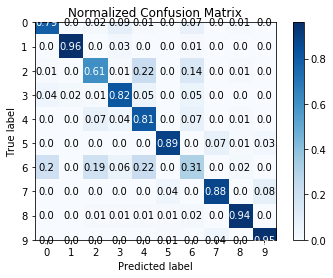

In [37]:
skplt.metrics.plot_confusion_matrix(train_set.targets, train_preds.argmax(dim=1), normalize=True)

In [38]:
# use ngrok to display TensorBoard on Colab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-10-25 19:59:45--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.228.157.109, 34.196.216.163, 34.236.110.238, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.228.157.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

100%[======================================>] 13,773,305  1.12MB/s   in 17s    

2019-10-25 20:00:03 (803 KB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [40]:
LOG_DIR = './runs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [41]:
get_ipython().system_raw('./ngrok http 6006 &')

In [42]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://675b8c52.ngrok.io
